# Train supervised models

Problem: predict lap time D laps in the future in a new event based on the historical event data.

Baseline: extract time series for all the events, generate fixed length input and label pairs. These data can be then used in supervised models, including RF, SVR and NN.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"

from indycar.notebook import *


Using TensorFlow backend.


### Load data and Initialization

In [2]:
# predict D lap in the future
D = 5 
# hidden utnits for LSTM
hunits = 16

In [3]:
#datalist = ['2017-all_completed_laps_diff.csv','2018-all_completed_laps_diff.csv' ]
datalist = ['2017-completed_laps_diff.csv','2018-completed_laps_diff.csv' ]
#datalist = read_list('train_all.list')
#datalist = read_list('train_completed.list')
scaler, dataset, dblens = load_data(datalist)

# get event idx
firstcar = np.cumsum(dblens)
event_idx = [0]
event_idx.extend(list(firstcar)[:-1])

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

load 2017-completed_laps_diff.csv, len=3216
load 2018-completed_laps_diff.csv, len=3618
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 3617
Data columns (total 8 columns):
Unnamed: 0        6834 non-null int64
car_number        6834 non-null int64
completed_laps    6834 non-null int64
rank              6834 non-null int64
elapsed_time      6834 non-null float64
rank_diff         6834 non-null float64
time_diff         6834 non-null float64
dbid              6834 non-null int64
dtypes: float64(3), int64(5)
memory usage: 480.5 KB
dataset shape (6834, 8)


In [4]:
# generate train/test dataset

# post-padding with 0
X, y, w = generate_data(dataset, D=D, target='time')

total = np.sum(dblens)
ntrain = np.sum(dblens[:-1])
nval = int(dblens[-1] / 2)
print('train=%d, val=%d, test=%d'%(ntrain, nval, total-ntrain-nval))

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]
#weights
w_train, w_val, w_test = w[:ntrain], w[ntrain:ntrain + nval], w[ntrain+nval:]
print('train shape:', X_train.shape)

carNumber = 34, max T =201
train=16, val=9, test=9
train shape: (16, 196, 1)


### convert time series into vectors

In [5]:
vec_len = 20
fv_x_train, fv_y_train, idx_train = generate_feature_vectors(X_train, y_train, w_train, vec_len)
fv_x_val, fv_y_val, idx_val = generate_feature_vectors(X_val, y_val, w_val, vec_len)
fv_x_test, fv_y_test, idx_test = generate_feature_vectors(X_test, y_test, w_test, vec_len)
#get event idx from idx array
first_in_event_idx = idx_train[event_idx[:-1]]

In [6]:
fv_x_train.shape, fv_x_test.shape, idx_train.shape

((2832, 20), (1593, 20), (16,))

In [7]:
#ts = X_train[0,:,0]
#ts[ts>0]

In [8]:
#ts = X_train[0,:,0]
#np.sum(ts>0)
#fv_x_train[-1], fv_y_train[-1]

In [ ]:
#ts_y = y_train[0,:,0]
#ts_y[ts>0]

In [ ]:
#firstcar = np.cumsum(dblens)
#idx = [0]
#idx.extend(list(firstcar)[:-1])
#plot_examples(X[idx],y[idx],ypreds=None,nm_ypreds=None)
#plot_examples(X[:10],y[:10],ypreds=None,nm_ypreds=None)

## Define model

In [7]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def lstm_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful=stateful,
                    name="RNN")(inp)

    #dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    dens = layers.Dense(in_out_neurons,name="dense")(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    #model = models.Model(inputs=[inp],outputs=[rnn])
    
    #model.compile(loss="mean_squared_error",
    #              sample_weight_mode="temporal",
    #              optimizer="rmsprop")
    
    model.compile(loss="mean_absolute_error",
                  #sample_weight_mode="temporal",
                  optimizer="adam")
    
    return(model,(inp,rnn))

def svr_model():
    return SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)

def rf_model():
    return RandomForestRegressor(max_depth=3, criterion='mae',random_state=0,
                             n_estimators=20, n_jobs=-1)



### SVR Model

In [8]:
print(fv_y_test[:10])
# svm model
svm_model = svr_model()
print(svm_model)
model_svm = svm_model.fit(fv_x_train,fv_y_train)
svm_result = predict('svr',model_svm, fv_x_test, fv_y_test, scaler)
print(svm_result[0][:10])

[0.20830371 0.21244506 0.21580858 0.20999909 0.2064805  0.20844144
 0.21167714 0.2088804  0.21470722 0.21012048]
SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr model mae=0.120831, raw mae=12.194428, raw mape=22.986108
[0.28625341 0.29431208 0.29501985 0.29468427 0.29322646 0.29407536
 0.29637476 0.29561933 0.29200189 0.29080298]


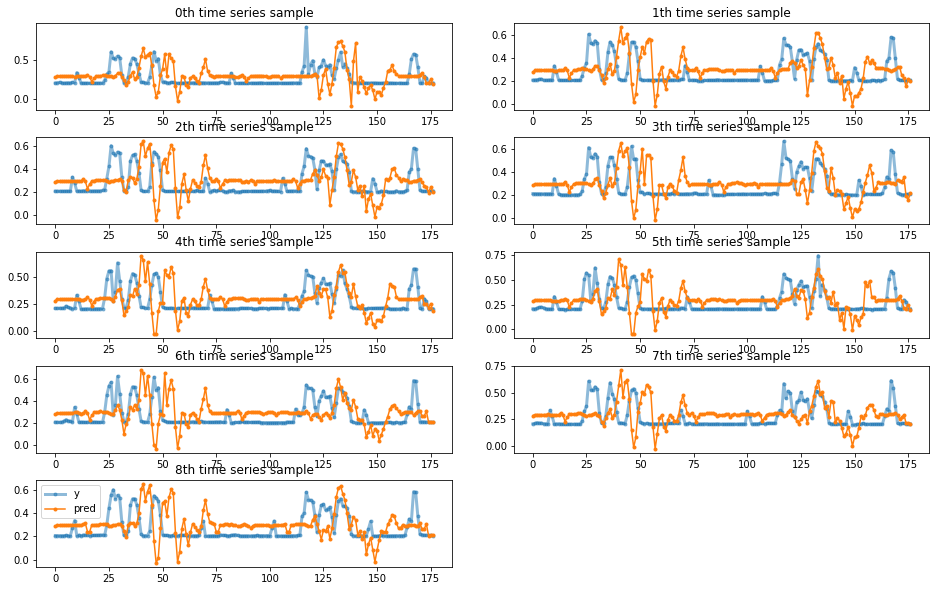

The final validation loss MAE is 0.120831


In [9]:
plot_vectors(fv_y_test,svm_result[0],idx_test)

In [ ]:
plot_vectors(fv_y_train,y_train_pred,idx_train[:8])

### RF model

In [10]:
# rf model
rf_ = rf_model()
print(rf_)
model_rf = rf_.fit(fv_x_train,fv_y_train)
rf_result = predict('rf', model_rf, fv_x_test, fv_y_test, scaler)
print(rf_result[0][:10])

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
rf model mae=0.071414, raw mae=7.207161, raw mape=8.751320
[0.20487346 0.20487346 0.20487346 0.20487346 0.20487346 0.20487346
 0.20487346 0.20487346 0.20487346 0.20487346]


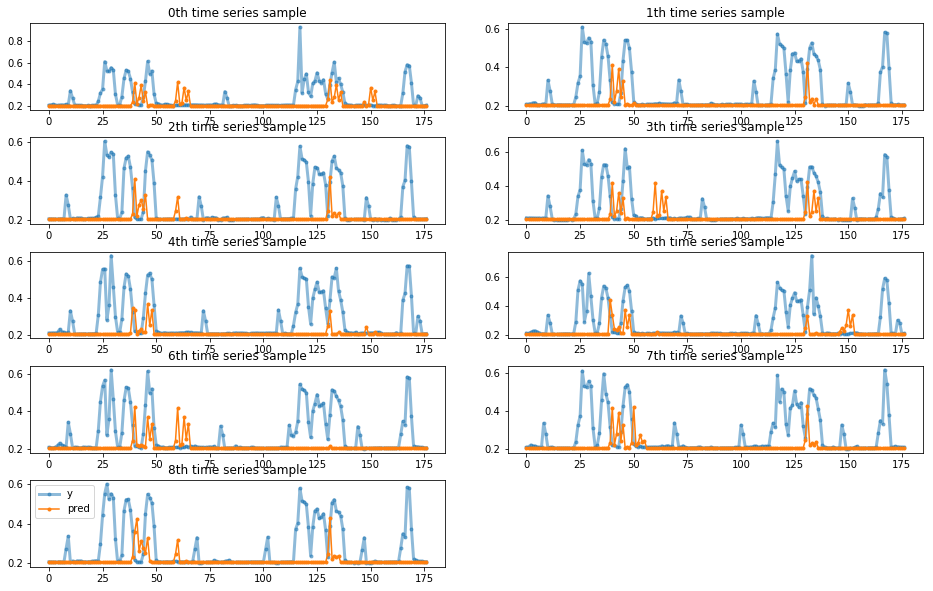

The final validation loss MAE is 0.071414


In [11]:
plot_vectors(fv_y_test,rf_result[0],idx_test)

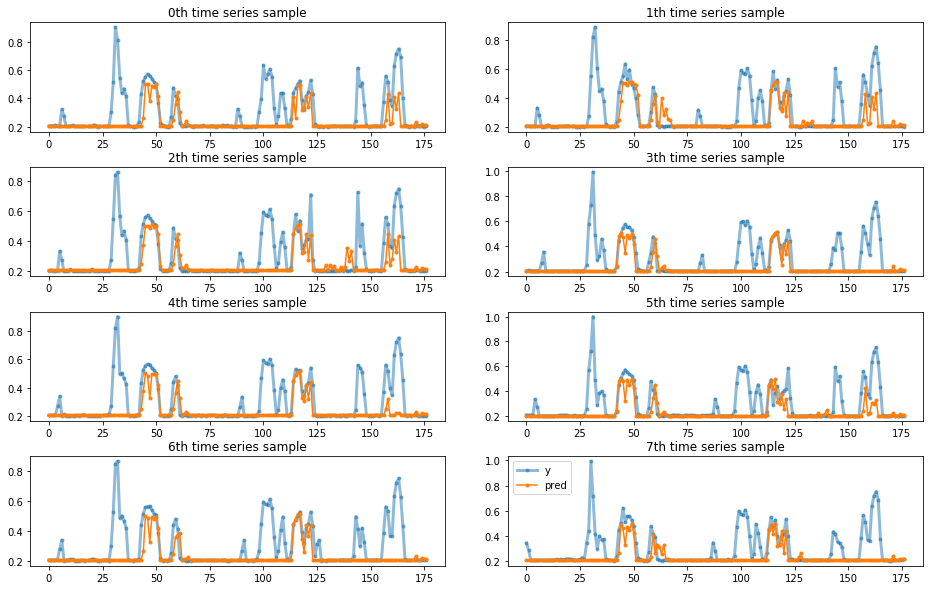

The final validation loss MAE is 0.072452


In [12]:
y_train_pred = model_rf.predict(fv_x_train)
plot_vectors(fv_y_train,y_train_pred,idx_train[:8])

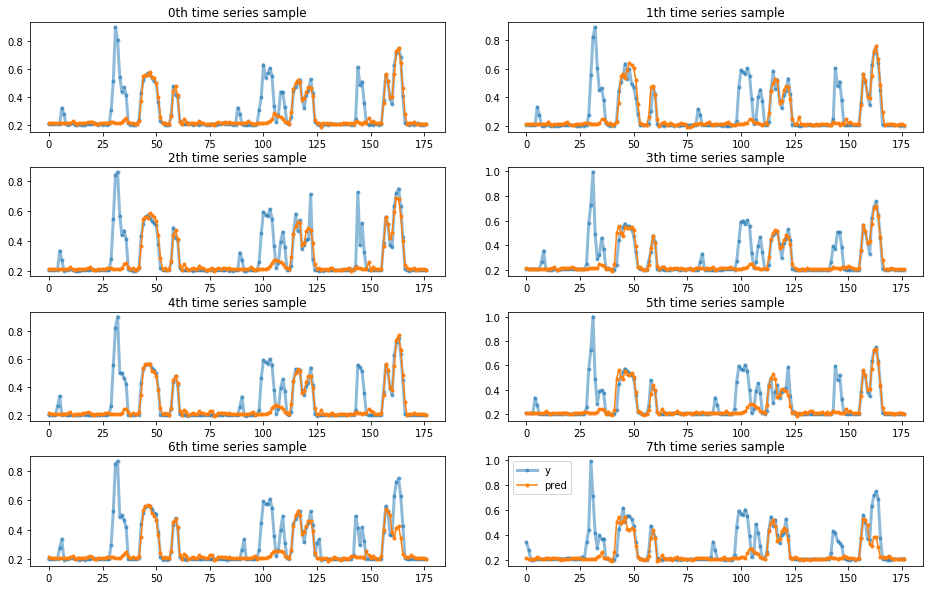

The final validation loss MAE is 0.053741


In [19]:
plot_vectors(fv_y_train,y_train_pred,idx_train[:8])

### LSTM model with short time-step

In [13]:
#lstm model
model_lstm, _ = lstm_model(
                    hidden_neurons = hunits,
                    len_ts = vec_len)
model_lstm.summary()
start = time.time()
n,m = fv_x_train.shape
val_n, val_m = fv_x_val.shape
w_train = np.ones((n,m))
w_val = np.ones((val_n,val_m))

history = model_lstm.fit(fv_x_train.reshape((n,m,1)),fv_y_train.reshape((n,1)),
                             batch_size=128,
                             shuffle=True,
                             epochs=500,
                             verbose=0,
                             validation_data=(fv_x_val.reshape((val_n,val_m,1)),
                                              fv_y_val.reshape((val_n,1))))
                             #sample_weight=w_train,                    
                             #validation_data=(fv_x_val.reshape((val_n,val_m,1)),
                             #                 fv_y_val.reshape((val_n,1)),w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 20, 1)             0         
_________________________________________________________________
RNN (LSTM)                   (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________

Time Took :4.39 min


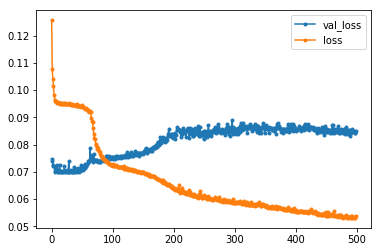

In [14]:
for line in history.history.keys():
    plt.plot(history.history[line],marker='.',label=line)
plt.legend()

lstm model mae=0.079616, raw mae=8.034907, raw mape=11.904366
[0.21109906 0.21132952 0.21108513 0.21114084 0.21064736 0.21099666
 0.21150999 0.21174599 0.2107068  0.21043348]


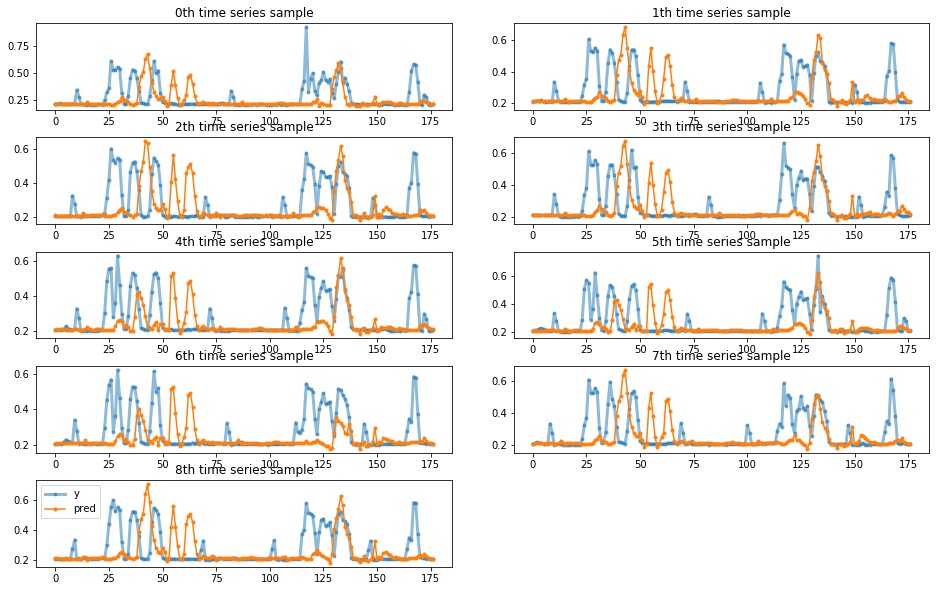

The final validation loss MAE is 0.079616


In [15]:
#n,m = fv_x_test.shape
#y_pred = model.predict(fv_x_test.reshape((n,m,1)))
#y_pred.shape
lstm_result = predict('lstm', model_lstm, fv_x_test, fv_y_test, scaler)
print(lstm_result[0][:10])
plot_vectors(fv_y_test,lstm_result[0],idx_test)

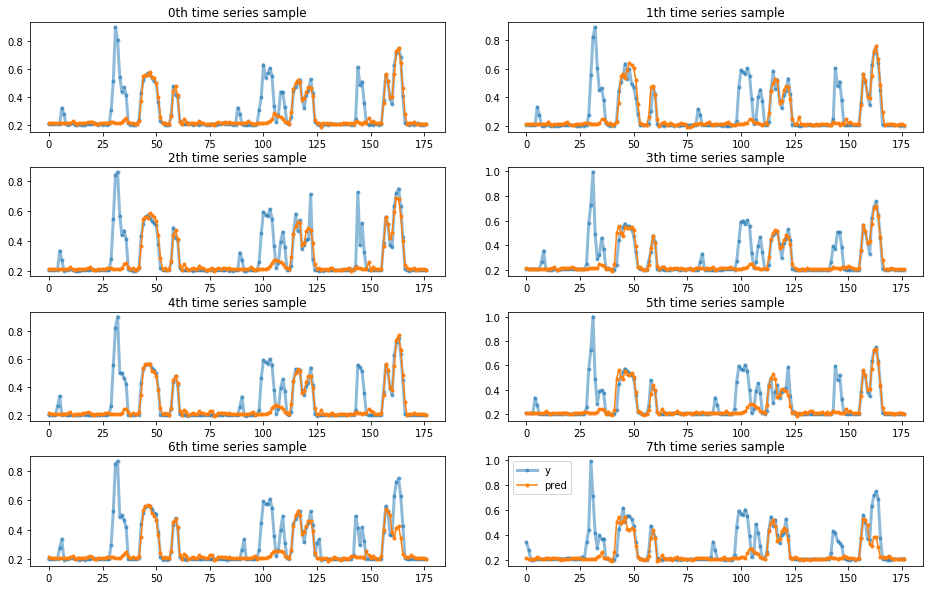

The final validation loss MAE is 0.053741


In [17]:
# training set
n,m = fv_x_train.shape
y_train_pred = model_lstm.predict(fv_x_train.reshape((n,m,1)))
plot_vectors(fv_y_train,y_train_pred,idx_train[:8])

### Result Analysis




In [18]:
mape = [x[3] for x in [svm_result, rf_result, lstm_result]]
namelist = ['svm','rf','lstm']
df=pd.DataFrame({'name':namelist, 'D=5':mape})
df

,name,D=5
0,svm,22.986108
1,rf,8.751320
2,lstm,11.904366


### conclusion
RF works better than lstm and svr (in current parameters). 

MAPE is as high as 11%-15%.